In [1]:
import numpy as np       # the NumPy library for fast matrix and vector data types and math operations
import matplotlib.pyplot as plt   # functions for plotting, loaded under a convenient name alias 'plt'
from pylab import plot, show, xlabel, ylabel, legend, semilogy,semilogx, grid, xlim, ylim, title,savefig, minorticks_on, figtext,text, errorbar
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
import csv
import pandas as pd
from astropy import modeling
from scipy import optimize
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.integrate import quad
import datetime
from datetime import timedelta
from datetime import datetime
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")

Some usefull constants and standard properties

In [2]:
Rgas=8.314 #J/mol/k
kB=1.38064852e-23 #m^2kg/(s^2K)
u=1.66e-27 #kg
NA=6.022140857e23 #number of atoms in a mol
eV=1.602176565e-19 #J
me=9.1093837015e-31 #kg

Material properties gallium

In [3]:
pa=0 # Assume pressure = 0 in Magnum Gallium properties
rho_Ga=5904 #kg/m^3
k_Ga=40.6 #W/mk
cp_Ga=371 #J/kgK
Evap_Ga = 258.7e3/NA #J/mol
M_Ga=69.723e-3 #kg/mol

In [4]:
def gaussian(x, amplitude, mean, stddev,offset): #make a funciton that returns a gaussian
    return amplitude * np.exp(-((x - mean)/ stddev)**2/ 2)+0

In [5]:
def Fitfunc(popt,pcov): #Add popt and pcov in the plot
    return (popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]))
B=['0','0',"0.6T","1.0T","1.3T","1.6T","1.6T"]  #magnetic field experiments
I=['0','0',"125A","125A","125A","125A","175A"] #Current experiments
cmap =['k','r','b','g','m','c']    #colours for figures 

Import Thomson data

In [6]:
x=np.arange(-25,25,0.1)
shotnr =[28927,28934,28938,28942,28946,28950]  #shot number of the first experiment
nrshots=[        4,    4,    4,    4,    4,    1]  #Number of shots per experiment

def TS(expnum):
    Ts = pd.DataFrame()
    for i in range(0,nrshots[expnum-1]):
        filename=('Thomson_2021-06-10_#' + str(shotnr[expnum-1]+i) + '.txt')
        df = pd.read_csv(filename, delimiter = "\t", skiprows=5, warn_bad_lines=True, error_bad_lines=False) #remove lines that do not have 5 columns 
        data_columns=df.columns.values
        num_df = (df.drop(data_columns, axis=1).join(df[data_columns].apply(pd.to_numeric, errors='coerce'))) #remove the lines that are not fully numerical
        num_df = num_df[num_df[data_columns].notnull().all(axis=1)]                                           #remove the lines that are not fully numerical
        num_df.index=list(range(0, len(num_df)))                                                              #sets the indec to start at 0 and increase by 1, row number
        ## There are 3 Thomson measurements per exp so we need to see which times correspond to thebegining and end of each exp. 
        difference = num_df.diff(axis=0) #difference between two consecutive rows
        if expnum==6:  #last experiment is only measured twice from which the last seems unrealistic
            t12=num_df[difference.iloc[:,0]<0].index.values #the 1st column is the position which per measurement always increases, so if the diff is negative it means we have a new measurement 
            Ts=pd.concat([Ts,num_df.iloc[0:t12[0]]])
            #Ts=pd.concat([Ts,num_df.iloc[0:t12[0]],num_df.iloc[t12[0]:len(num_df)]]) #Uncomment this line to see the unrealistic second measurement 
        else:
            Ts=pd.concat([Ts,num_df]) #Combination of all the experimental data (measured at different times)
            
    popt, pcov = optimize.curve_fit(gaussian, Ts.iloc[:,0], Ts.iloc[:,2],[3,3,1,0],bounds=((0, -np.inf,0, -np.inf),(np.inf,np.inf,np.inf, np.inf))) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    popt_n, pcov_n = optimize.curve_fit(gaussian, Ts.iloc[:,0], (Ts.iloc[:,1]*1e-19),[2,3,6,3]) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    return Ts,popt,pcov,popt_n,pcov_n


Plot TS data

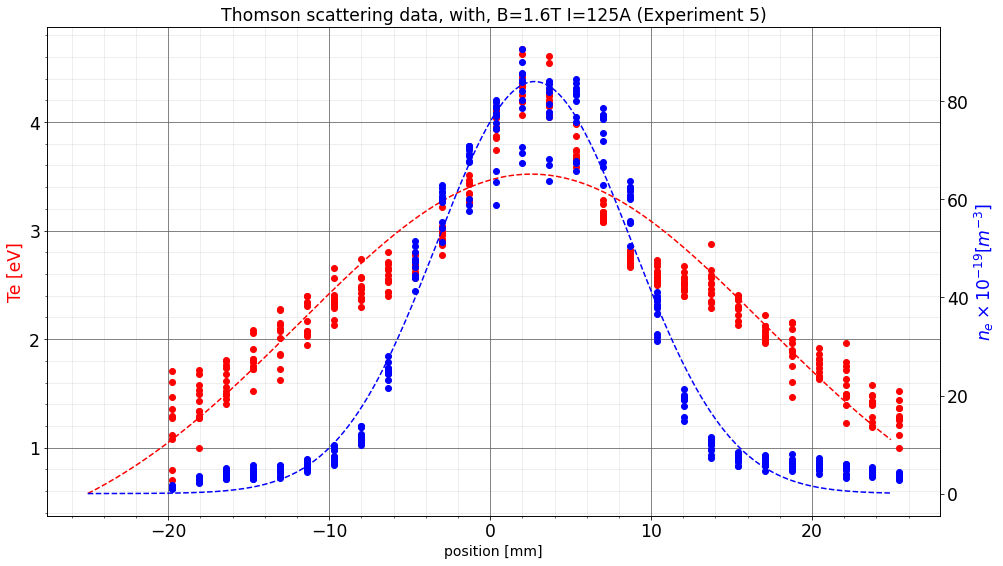

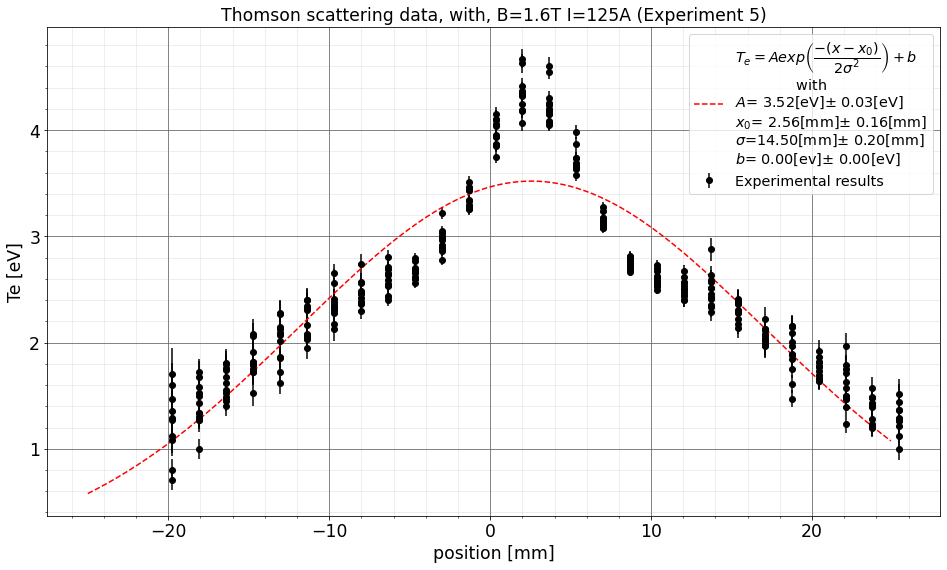

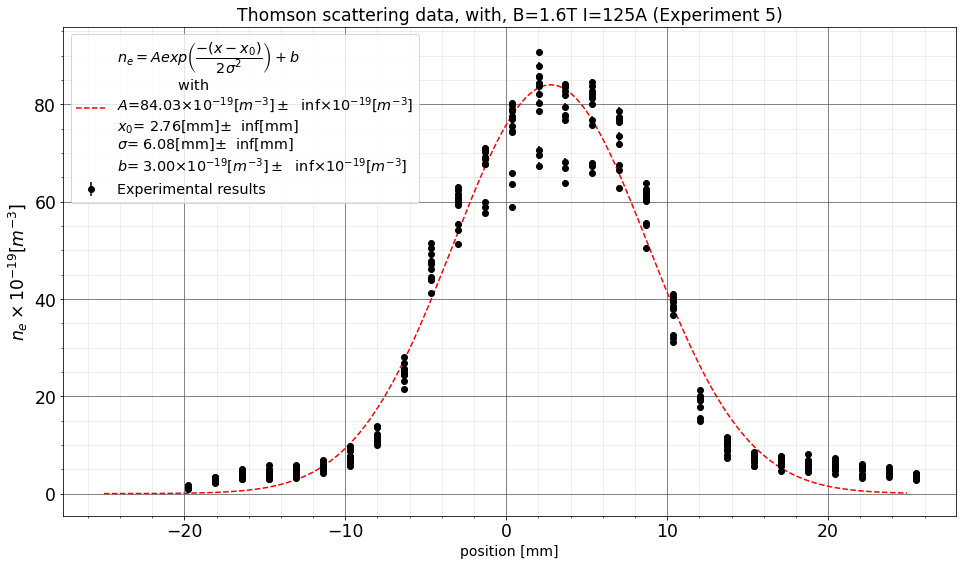

In [24]:
expnum=5
Ts,popt,pcov,popt_n,pcov_n=TS(expnum)

fig,ax = plt.subplots()
ax.plot(Ts.iloc[:,0],Ts.iloc[:,2],'or')
ax.plot(x, gaussian(x, *popt),'--r')
xlabel('position [mm]', fontsize=14)
ylabel('Te [eV]', color="red")

grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)

ax2=ax.twinx()
ax2.plot(Ts.iloc[:,0],Ts.iloc[:,1]*1e-19,'ob')
ax2.set_ylabel(r'$n_e \times 10^{-19} [ m^{-3}]$', color="blue")
ax2.plot(x, gaussian(x, *popt_n),'--b')
title('Thomson scattering data, with, B=' + str(B[expnum]) + ' I='+ str(I[expnum])+' (Experiment '+ str(expnum)+')')
#savefig('Figures/Ts_exp_' + str(expnum) + '.png', dpi=1000)
show()


plt.errorbar(Ts.iloc[:,0],Ts.iloc[:,2], yerr=Ts.iloc[:,4], fmt='o', color='k', label='Experimental results')
plot(x, gaussian(x, *popt),'--r',label=r"$T_e=Aexp\left(\dfrac{-(x-x_0)}{2\sigma^2}\right)+b$" "\n" "$\qquad\qquad$ with" "\n" "$A$=%5.2f[eV]$\pm$%5.2f[eV]" "\n" "$x_0$=%5.2f[mm]$\pm$%5.2f[mm]" "\n" "$\sigma$=%5.2f[mm]$\pm$%5.2f[mm]" "\n" "$b$=%5.2f[ev]$\pm$%5.2f[eV]" % (Fitfunc(popt,pcov)))
xlabel('position [mm]')
ylabel('Te [eV]')
title('Thomson scattering data, with, B=' + str(B[expnum]) + ' I='+ str(I[expnum])+' (Experiment '+ str(expnum)+')')
legend()
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
savefig('Figures/Te_Ts_exp_' + str(expnum) + '.png', dpi=1000)
show()


plt.errorbar(Ts.iloc[:,0],Ts.iloc[:,1]*1e-19, yerr=Ts.iloc[:,3]*1e-19,  fmt='o', color='k', label='Experimental results')
plot(x, gaussian(x, *popt_n),'--r',label=r"$n_e=Aexp\left(\dfrac{-(x-x_0)}{2\sigma^2}\right)+b$" "\n" "$\qquad\qquad$ with" "\n" r"$A$=%5.2f$\times 10^{-19}[m^{-3}] \pm$%5.2f$\times 10^{-19}[m^{-3}]$" "\n" "$x_0$=%5.2f[mm]$\pm$%5.2f[mm]" "\n" "$\sigma$=%5.2f[mm]$\pm$%5.2f[mm]" "\n" r"$b$=%5.2f$\times 10^{-19}[m^{-3}]\pm$%5.2f$\times 10^{-19}[m^{-3}]$" % (Fitfunc(popt_n,pcov_n)))
xlabel('position [mm]', fontsize=14)
ylabel(r'$n_e \times 10^{-19} [ m^{-3}]$')
title('Thomson scattering data, with, B=' + str(B[expnum]) + ' I='+ str(I[expnum])+' (Experiment '+ str(expnum)+')')
legend()
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
savefig('Figures/ne_Ts_exp_' + str(expnum) + '.png', dpi=1000)
show()

Calometry calibration

In [7]:
cp=4200 #J/kg/K
E=97320 #J

data=pd.read_csv("temp.csv", delimiter='|', skiprows=1)   #Import calorimetry calibration data
data["Date/Time"] = [datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in data["Date/Time"]] # converts the time strings to readable datetime
time_int=data["Date/Time"]-data["Date/Time"][0]
time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
data = data.assign(t=time_int2) # assign the interval found in seconds as a column
data.Value=data.Value-data.Value.iloc[0:37].mean() #subtract theoffset
Tint=np.trapz(data.Value,data.t) #integrated delta temperature
mflow=E/(Tint*cp) #[kg/s]


In [8]:
datacal=pd.read_csv("calorimetry.csv", delimiter='|', skiprows=1)   #Import the experimental data
datacal["Date/Time"] = [datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in datacal["Date/Time"]] # converts the time strings to readable datetime
tstartcal=["2021-06-10 11:44","2021-06-10 13:47","2021-06-10 14:12","2021-06-10 14:38","2021-06-10 14:53","2021-06-10 15:07"]
tstartcal= [datetime.strptime(x,'%Y-%m-%d %H:%M') for x in tstartcal] # converts the time strings to readable datetime
tendcal=[tstartcal[x]+timedelta(seconds=14*60) for x in range(len(tstartcal))] # sets the end of the experiments 20 minutes after the start

def calo(expnum):
    ind1=datacal[datacal["Date/Time"]>tstartcal[expnum-1]].index[expnum-1] #index start time
    ind2=datacal[datacal["Date/Time"]<tendcal[expnum-1]].index[-1] #index end time
    tint=datacal["Date/Time"].iloc[ind1:ind2] # Indexes of the complete experiment
    offset=datacal.Value.iloc[ind1-100:ind1].mean() # Takes the average of the 100 sec before the experiment as a base value 

    #Set expi to the values beloning to this experiment
    expi = pd.DataFrame(columns = ["time", "temp"])
    expi=expi.assign(time=datacal["Date/Time"].iloc[ind1:ind2])
    expi=expi.assign(temp=datacal.Value.iloc[ind1:ind2]-offset) 
    time_int=expi.time-expi.time.iloc[0]
    time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
    expi = expi.assign(t=time_int2) # assign the interval found in seconds as a column
    # THIS IS NEW I AM TRYTING TO DETERMINE THE MAX TEMPERATURE ON THE TOP WHICH IS THE AVERAGE
    # OF THE TIMES 300 TO 400
    TtopFINAL=expi[expi.t<400].index[-1]
    TtopSTART=expi[expi.t>300].index[0]
    Tmax=expi.loc[TtopSTART:TtopFINAL].temp.mean()
    P=mflow*(Tmax*cp)

    ## Old
#     Tint=np.trapz(expi.temp,expi.t)
#     E=mflow*(Tint*cp) #[J]
#     Pold=E/420  # [W] divided by 7 min(the length of the experiment)
    return expi, P


In [9]:
data=pd.read_excel("Pyrometer_data_2021_06_09.xlsx")   #Import the experimental data
data.time = [datetime.strptime(x,'%H:%M:%S.%f') for x in data.time] # converts the time strings to readable datetime
t_diff= [(data.time.diff()).iloc[x].seconds for x in range(len(data))]; # determine the difference between two lines
tstart=data[(np.array(t_diff)>120)] #when the difference is larger than 2min (120sec) the expriment has ended 
tend=data.iloc[tstart.index-1]
tend=pd.concat([tend,(data.iloc[len(data)-1:len(data)])])
tstart

IRnum_empty=[0,3,12,15,18] #There is no Pyrometer data for the first two experiments
IRnum=[0,7,13,19,20,21] #There is no Pyrometer data for the first two experiments
    
def T_exp(expnum,Emp=0):
    if Emp ==0:
        i=IRnum[expnum-1]
    else:
        i=IRnum_empty[expnum-1]
        
    IR=pd.read_csv("IR"+ str(i+3)+".txt", delimiter = "\t")   #Import the experimental data
    IR=IR.rename(columns={'(time)': 'time', "1 Mean  (°C)":'temp' })
    IR.time = [datetime.strptime(x,'%H:%M:%S.%f') for x in IR.time] # converts the time strings to readable datetime
    timeIR=IR.time-IR.time[0]
    timeIR2= [timeIR.iloc[ii].total_seconds() for ii in range(len(timeIR))] #convert time to seconds
    IR = IR.assign(t=timeIR2)
    
    Pyro=data.iloc[tstart.index[i]:tend.index[i+1]+1]
    time_int=data.time.iloc[tstart.index[i]:tend.index[i+1]+1]-IR.time.iloc[0] #find the time interval from experiment i and subtract the time at which the IR camera started measuring 
    time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
    Pyro = Pyro.assign(t=time_int2) # assign the interval found in seconds as a column
    return Pyro, IR




In [19]:
RiE = 0.4  #Reflection energy
ReE = 0.15  
RiN =0.6
Xr = 0.0  # energy molecular recombination
Xi = 24.6  # energy depostion by ion
delta=0

mi=4*u # mass helium ion 
gam=1.66 # heat capacity ratio 

# Assumptions 
Tatent=1 
M=0.5 # Machnumber


def qsheathraw(expnum): 
    Ts,popt,pcov,popt_n,pcov_n=TS(expnum)
    Te=Ts.iloc[:,2]
    ne=Ts.iloc[:,1]
    Ti=Te
    Vps=np.log(0.5) # Assume Collisionless 
    Vfl=0.5*Te*np.log((2*np.pi*me/mi)*(1+Ti/Te)*(1/(1-delta)**2))
    qtot=(2.5*Te-Vfl-Vps*Te)*(1-RiE)+2*Te*(1-ReE)+Xi+Xr*(1-RiN)
    gamma=qtot/Te
    Gam=(1+M**2)/2*ne*np.sqrt((gam+1)*Tatent*Te*eV/mi)
    qsheath=Gam*eV*Tatent*Te*gamma
    return qsheath*1e-6

def qsheath(expnum, total=0):
    Ts,popt,pcov,popt_n,pcov_n=TS(expnum)
    if total==0:
        Te=popt[0]+popt[3] #offset plus amplitude
        ne=(popt_n[0]+popt_n[3])*1e19 #offset plus amplitude
    else:
        Te=gaussian(x, *popt)
        ne=gaussian(x, *popt_n)*1e19
    Ti=Te
    Vps=np.log(0.5) # Assume Collisionless 
    Vfl=0.5*Te*np.log((2*np.pi*me/mi)*(1+Ti/Te)*(1/(1-delta)**2))
    qtot=(2.5*Te-Vfl-Vps*Te)*(1-RiE)+2*Te*(1-ReE)+Xi+Xr*(1-RiN)
    gamma=qtot/Te
    Gam=(1+M**2)/2*ne*np.sqrt((gam+1)*Tatent*Te*eV/mi)
    qsheath=Gam*eV*Tatent*Te*gamma
    return qsheath*1e-6

#NEW new q to caultulate the heat flux using calorimetry power and using the heat flux gaussian centre and sigma
def qrawcalo(expnum): # [x]=mm, [q]=MW
    Ts,popt,pcov,popt_n,pcov_n=TS(expnum)
    pop_qsheathraw, pcov = optimize.curve_fit(gaussian, Ts.iloc[:,0], qsheathraw(expnum),[3,3,1,0],bounds=((0, -np.inf,0, -np.inf),(np.inf,np.inf,np.inf, np.inf))) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    x0_q = pop_qsheathraw[1]
    sig_q = pop_qsheathraw[2]
    expi, P=calo(expnum)
    integg=2*np.pi*sig_q**2*(1-np.exp(-12*12/(2*sig_q**2))) #it is not until infinity
    A=P/(2*np.pi*sig_q**2)
    q=gaussian(x, A,x0_q, sig_q,0)
    return q

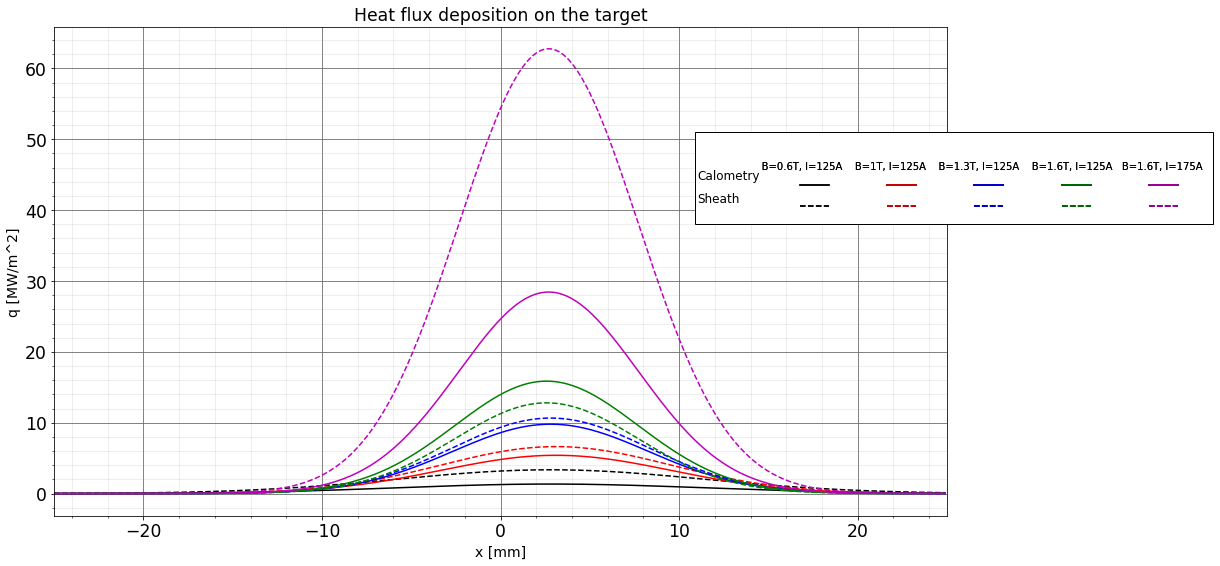

In [41]:
# NEW Heat flux from calorimetry and TS using the sheath theory shape and raw data, no fit except to the heat flux from TS to get the shape for the calorimetry
a= [None, None, None, None, None]
b= [None, None, None, None, None] 

for i in range(1,6):
    Ts,popt,pcov,popt_n,pcov_n=TS(i)
    popt_qsheathraw, pcov_qsheathraw = optimize.curve_fit(gaussian, Ts.iloc[:,0], qsheathraw(i),[1,1,1,0],bounds=((0, -np.inf,0, -np.inf),(np.inf,np.inf,np.inf, np.inf))) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    a[i-1], =plot(x,qrawcalo(i),color = cmap[i-1],linestyle='solid',label='Raw TS data  B=' + str(B[i]) + ' I='+ str(I[i]))
    b[i-1], =plot(x, gaussian(x, *popt_qsheathraw),color = cmap[i-1],linestyle='dashed',label='Raw TS data  B=' + str(B[i]) + ' I='+ str(I[i]))

##--------------------------------LEGEND ------------------------
line_columns = [
                a[0], b[0],
                (a[0], a[1]), (b[0],b[1]),
                (a[0],a[2]),  (b[0],b[2]),
                (a[0], a[3]), (b[0], b[3]),
                (a[0], a[4]), (b[0], b[4])
                ]
leg = plt.legend(line_columns, ['hh']*len(line_columns),  
             title="     B=0.6T, I=125A    B=1T, I=125A    B=1.3T, I=125A    B=1.6T, I=125A   B=1.6T, I=175A",  
             ncol=5, numpoints=1, labelcolor='w',markerfirst=False, bbox_to_anchor=(0.76, 0.75),frameon=False)
x_pos = 8+3
y_pos = 44.4
y_pos2 = 41.1
plt.text(x_pos, y_pos, "Calometry", fontsize='large').set_zorder(6)
plt.text(x_pos, y_pos2, "Sheath", fontsize='large').set_zorder(7)
plt.gca().add_artist(leg).set_zorder(5)
plt.gca().add_patch(
    Rectangle(
        (10.9, 38),
        29,
        13,
        edgecolor = 'k',
        facecolor = 'white',
         clip_on=False,
        fill=True
     ) ).set_zorder(4)


xlim(-25,25)
##------------------------------------LEGEND ------------------------
xlabel('x [mm]', fontsize=14)
ylabel('q [MW/m^2]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Heat flux deposition on the target')
# legend()
#savefig('Figures/q_sheath_Calo.png', dpi=1000)
plt.show()

In [42]:
T = np.arange(273.15, 3574.15, 0.01)  # Set the surface temperature as a variable
Tcool=20+273.15#C

def qmod(T,R, C, eps_cool):
    pv_Ga=10**(-13984/T-0.31413*np.log10(T)+11.76)
    Gam_vap_Ga=(pv_Ga-pa)/np.sqrt(2*np.pi*M_Ga*u*kB*T)
    qcond_Ga=C*(T-Tcool)
    qplasma_Ga=qcond_Ga+Gam_vap_Ga*(1-R)*(eps_cool*eV+Evap_Ga)
    return qplasma_Ga*1e-6


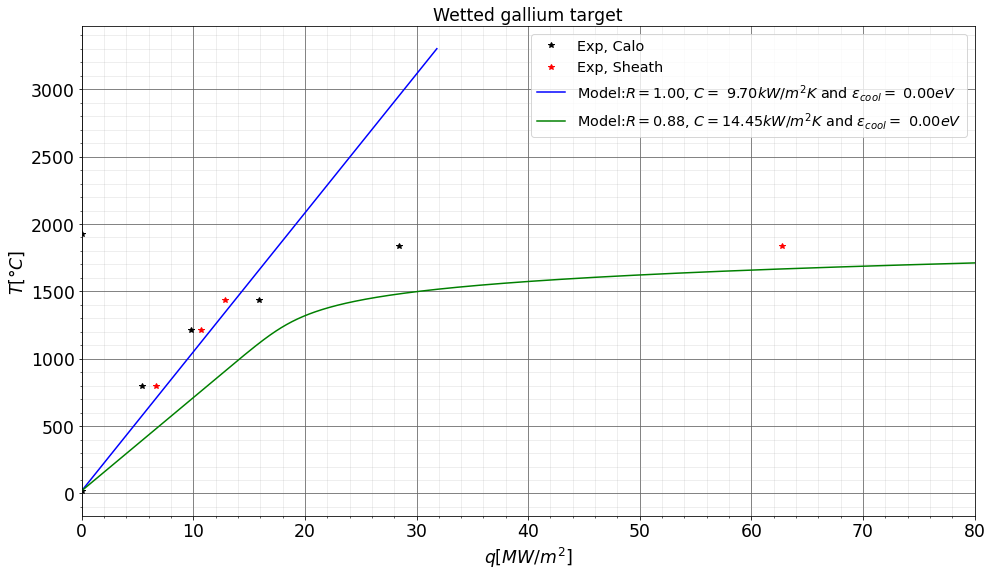

In [43]:
qmax = np.zeros(7)
qsheathmax = np.zeros(7)
Tsat= np.zeros(7)

for i in range(2,7):
    Tsat[i]=np.mean(T_exp(i)[1].temp[T_exp(i)[1][T_exp(i)[1].t<20].index[-1]:T_exp(i)[1][T_exp(i)[1].t<20.5].index[-1]])# mean temperature between 20s and 20.5s for exp3
    qmax[i]=np.max(qrawcalo(i))
    Ts,popt,pcov,popt_n,pcov_n=TS(i)
    popt_qsheathraw, pcov_qsheathraw = optimize.curve_fit(gaussian, Ts.iloc[:,0], qsheathraw(i),[1,1,1,0],bounds=((0, -np.inf,0, -np.inf),(np.inf,np.inf,np.inf, np.inf))) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    qsheathmax[i]=np.max(gaussian(x, *popt_qsheathraw))
Tsat[1]=20

plot(qmax[1:len(Tsat)],Tsat[1:len(Tsat)], 'k*',label='Exp, Calo')
plot(qsheathmax[2:len(Tsat)],Tsat[2:len(Tsat)], 'r*',label='Exp, Sheath')

#popt_qmod, pcov_qmod =optimize.curve_fit(qmod, np.concatenate((Tsat[2:len(Tsat)], Tsat[2:len(Tsat)])),np.concatenate((qmax[2:len(Tsat)],qsheathmax[2:len(Tsat)])),[0.9,8e3,1*eV]) # Fit of both the Calo and  sheath
popt_qmod, pcov_qmod =optimize.curve_fit(qmod, Tsat[1:len(Tsat)],qmax[1:len(Tsat)],[0.9,5e3,1],bounds=((0, 0, 0),(1,np.inf,np.inf))) #Only Calo for the fit 
plot(qmod(T,*popt_qmod),T-273.15, 'b-',label='Model:$R=$%2.2f, $C=$%5.2f$kW/m^2K$ and $\epsilon_{cool}=$%5.2f$eV$'% (popt_qmod[0], popt_qmod[1]*1e-3, popt_qmod[2]))
popt_qmod, pcov_qmod =optimize.curve_fit(qmod, np.concatenate((Tsat[2:len(Tsat)], Tsat[2:len(Tsat)])),np.concatenate((qmax[2:len(Tsat)],qsheathmax[2:len(Tsat)])),[0.9,8e3,1*eV]) # Fit of both the Calo and  sheath
plot(qmod(T,*popt_qmod),T-273.15, 'g-',label='Model:$R=$%2.2f, $C=$%5.2f$kW/m^2K$ and $\epsilon_{cool}=$%5.2f$eV$'% (popt_qmod[0], popt_qmod[1]*1e-3, popt_qmod[2]))
#plot(qmod(T,0.99, 5e3, 5),T-273.15, 'g-',label='Model:$R=0.99$, $C=5kW/m^2K$ and $\epsilon_{cool}=5eV$')

xlabel('$q [MW/m^2]$')
ylabel('$T[\degree C]$')
xlim(0, 80)
legend()
ax.yaxis.label.set_color('black')
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Wetted gallium target')
savefig('Figures/Wetted_Ga_qT.png', dpi=1000)
show()

In [13]:
qrange= np.arange(0, 80, 0.01)
Tmelt_W=3422*np.ones(len(qrange))
Tboil_Ga=2229*np.ones(len(qrange))

kW=170 #W/mK
l=17e-3#m
eps=0.5 #porosity
qW=eps*kW*(T-Tcool)/l*1e-6

Tsat_emptypyro= np.zeros(6)
Tsat_empty= np.zeros(6)

for i in range(2,6):
    Tsat_emptypyro[i]=np.mean(T_exp(i,1)[0].temp.loc[T_exp(i,1)[0][T_exp(i,1)[0].t<12.2].index[-1]:T_exp(i,1)[0][T_exp(i,1)[0].t<12.5].index[-1]])# mean temperature between 20s and 20.5s for exp3
    Tsat_empty[i]=np.mean(T_exp(i,1)[1].temp[T_exp(i,1)[1][T_exp(i,1)[1].t<20].index[-1]:T_exp(i,1)[1][T_exp(i,1)[1].t<20.5].index[-1]])# mean temperature between 20s and 20.5s for exp3

plot(qmax[2:len(Tsat)],Tsat[2:len(Tsat)], 'k*',label='Exp, Calo wetted IR')
plot(qsheathmax[2:len(Tsat)],Tsat[2:len(Tsat)], 'r*',label='Exp, Sheath wetted IR')
# plot(qmax[0:6],Tsat_empty, 'ko',label='Exp, Calo empty target IR')
# plot(qsheathmax[0:6],Tsat_empty, 'ro',label='Exp, TS empty target IR')
plot(qmax[0:6],Tsat_emptypyro, 'k<',label='Exp, Calo empty target Pyro')
plot(qsheathmax[0:6],Tsat_emptypyro, 'r<',label='Exp, TS empty target Pyro')
popt_qmod, pcov_qmod =optimize.curve_fit(qmod, Tsat[1:len(Tsat)],qmax[1:len(Tsat)],[0.9,5e3,1],bounds=((0, 0, 0),(1,np.inf,np.inf))) #Only Calo for the fit 
plot(qmod(T,*popt_qmod),T-273.15, 'b-',label='Model:$R=$%2.2f, $C=$%5.2f$kW/m^2K$ and $\epsilon_{cool}=$%5.2f$eV$'% (popt_qmod[0], popt_qmod[1]*1e-3, popt_qmod[2]))
popt_qmod, pcov_qmod =optimize.curve_fit(qmod, np.concatenate((Tsat[2:len(Tsat)], Tsat[2:len(Tsat)])),np.concatenate((qmax[2:len(Tsat)],qsheathmax[2:len(Tsat)])),[0.9,8e3,1*eV]) # Fit of both the Calo and  sheath
plot(qmod(T,*popt_qmod),T-273.15, 'g-',label='Model:$R=$%2.2f, $C=$%5.2f$kW/m^2K$ and $\epsilon_{cool}=$%5.2f$eV$'% (popt_qmod[0], popt_qmod[1]*1e-3, popt_qmod[2]))
#plot(qmod(T,0.99, 5e3, 5),T-273.15, 'g-',label='Model:$R=0.99$, $C=5kW/m^2K$ and $\epsilon_{cool}=5eV$')

plot(qrange,Tmelt_W,'c--')
plot(qrange,Tboil_Ga,'c--')
text(60, Tmelt_W[0]+50, '$T_{m,W}$', fontsize=12,color='c')
text(60, Tboil_Ga[0]+50,'$T_{b,Ga}$', fontsize=12,color='c')

plot(qW,T-273.15,'m--',label='Pure conduction in W, $\epsilon=50\%$')
xlabel('$q [MW/m^2]$')
ylabel('$T[\degree C]$')
xlim(0, 80)
legend()
ax.yaxis.label.set_color('black')
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Gallium experiment')
savefig('Figures/Ga_qT.png', dpi=1000)
show()

NameError: name 'T' is not defined